# Time-Series Forecasting for US Liquor Sales
This notebook details the process of using time series analysis to forecast monthly US beer, wine and liquor sales. The data is downloaded from the <a href=https://www.census.gov/econ/currentdata/dbsearch?program=MRTS&startYear=1992&endYear=2018&categories=44X72&dataType=SM&geoLevel=US&adjusted=1&notAdjusted=1&errorData=0>United States Census Bureau.</a> 

Codes with functions are hidden for readability and can be made visible by using the View > Cell Toolbar > Hide Code
All functions are adapted from <a href=https://github.com/SimiY/pydata-sf-2016-arima-tutorial >PyData 2016.</a> 

In [1]:
# Import All Necessary Packages
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# Remote Data Access
import pandas_datareader.data as web
import datetime
# reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.graphics.api import qqplot

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [2]:
# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

### Step1 : Import Time Series. Split into Train and Validation Data

In time series analysis, it is important to not randomly split the data into training and validation as this will affect the structure. Instead, the latest data is designated as validation data upon which the time series algorithm is tested. For the liquor series, we will forecast on the latest 14 months.

In [3]:
# Step 1
# Read in liquor sales data. Change index of column to monthly dates provided
liquor = pd.read_csv('data/liquor.csv', header=0, index_col=0, parse_dates=[0])

n_forecast = 14
n_train = liquor.shape[0]-n_forecast

liquor_train = liquor.iloc[:n_train]['Value']
liquor_valid = liquor.iloc[n_train:]['Value']
print(liquor_train.shape)
print(liquor_valid.shape)
print("Training Series:", "\n", liquor_train.tail(), "\n")
print("Validation Series:", "\n", liquor_valid.head())

(279,)
(14,)
Training Series: 
 Period
2014-11-01    4133
2014-12-01    5606
2015-01-01    3576
2015-02-01    3517
2015-03-01    3881
Name: Value, dtype: int64 

Validation Series: 
 Period
2015-04-01    3864
2015-05-01    4369
2015-06-01    4241
2015-07-01    4524
2015-08-01    4248
Name: Value, dtype: int64


### Step 2: Exploratory Data Analysis

In [4]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", liquor_train.shape, "\n")
print("First 5 observations of the training data series:", "\n", liquor_train.head(), "\n")
print("Last 5 observations of the validation data series:", "\n", liquor_valid.tail())

Data shape: (279,) 

First 5 observations of the training data series: 
 Period
1992-01-01    1509
1992-02-01    1541
1992-03-01    1597
1992-04-01    1675
1992-05-01    1822
Name: Value, dtype: int64 

Last 5 observations of the validation data series: 
 Period
2016-01-01    3559
2016-02-01    3718
2016-03-01    3986
2016-04-01    4043
2016-05-01    4311
Name: Value, dtype: int64


We will use autocorrelation plots and partial autocorrelation plots as our main tools of time series analysis. Other plots such as the data itself and histogram can tell us whether the time-series complies with stationarity.

What is stationarity?

Stationarity is defined as constant mean and variance in the entire time series. Any time-series data needs to hold some sort of stationarity so that algorithms can determine the structure present in the series. If no stationarity is encountered, any transform can be performed. The usual transforms that are applied are log-transformations and differencing the time-series.

How to test for stationarity?

The histogram plot must resemble a normal distribution. The time-series data must not have any trend. The mean and variance must be constant. p-value specified below can be used to find out the stationarity of a series. If p-value is less than 0.05, then we can say that the time-series complies with stationarity.

In [5]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

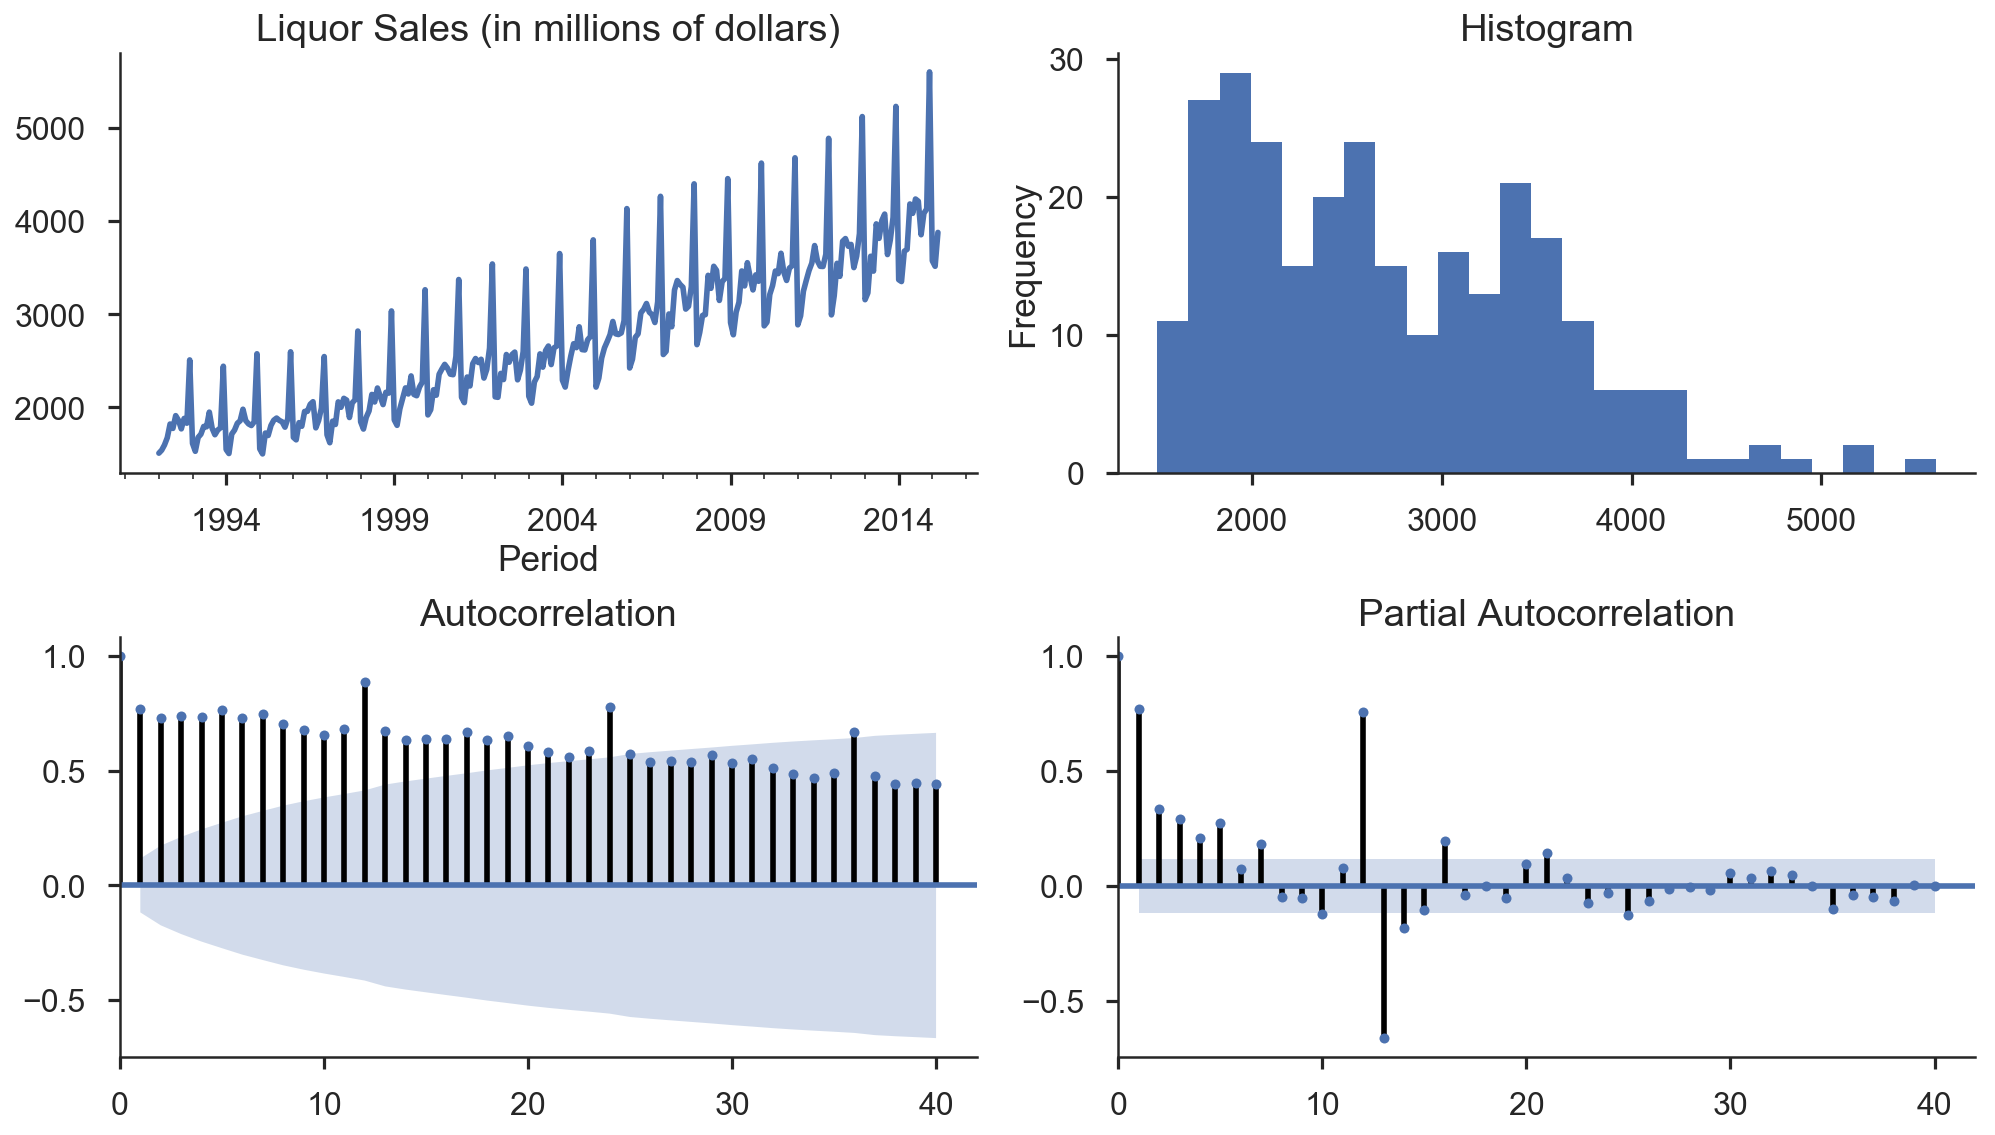

In [6]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
tsplot(liquor_train, title='Liquor Sales (in millions of dollars)', lags=40);

From the above plots, we can easily show that the original time-series is not showing stationarity as there is a clear rising trend in liquor sale value. The histogram is not a normal distribution. Also, the variance increases with time. We should expect this time-series to fail the stationarity test.

In [7]:
# Testing for stationarity
test_stationarity(liquor_train)

Test Statistic                  1.84537
p-value                         0.99843
#Lags Used                     16.00000
Number of Observations Used   262.00000
Critical Value (1%)            -3.45556
Critical Value (5%)            -2.87264
Critical Value (10%)           -2.57268
dtype: float64

From the above stationarity test, we see that p-value is greater than 0.05. We employ a log-transformation and see if there is any difference in stationarity.

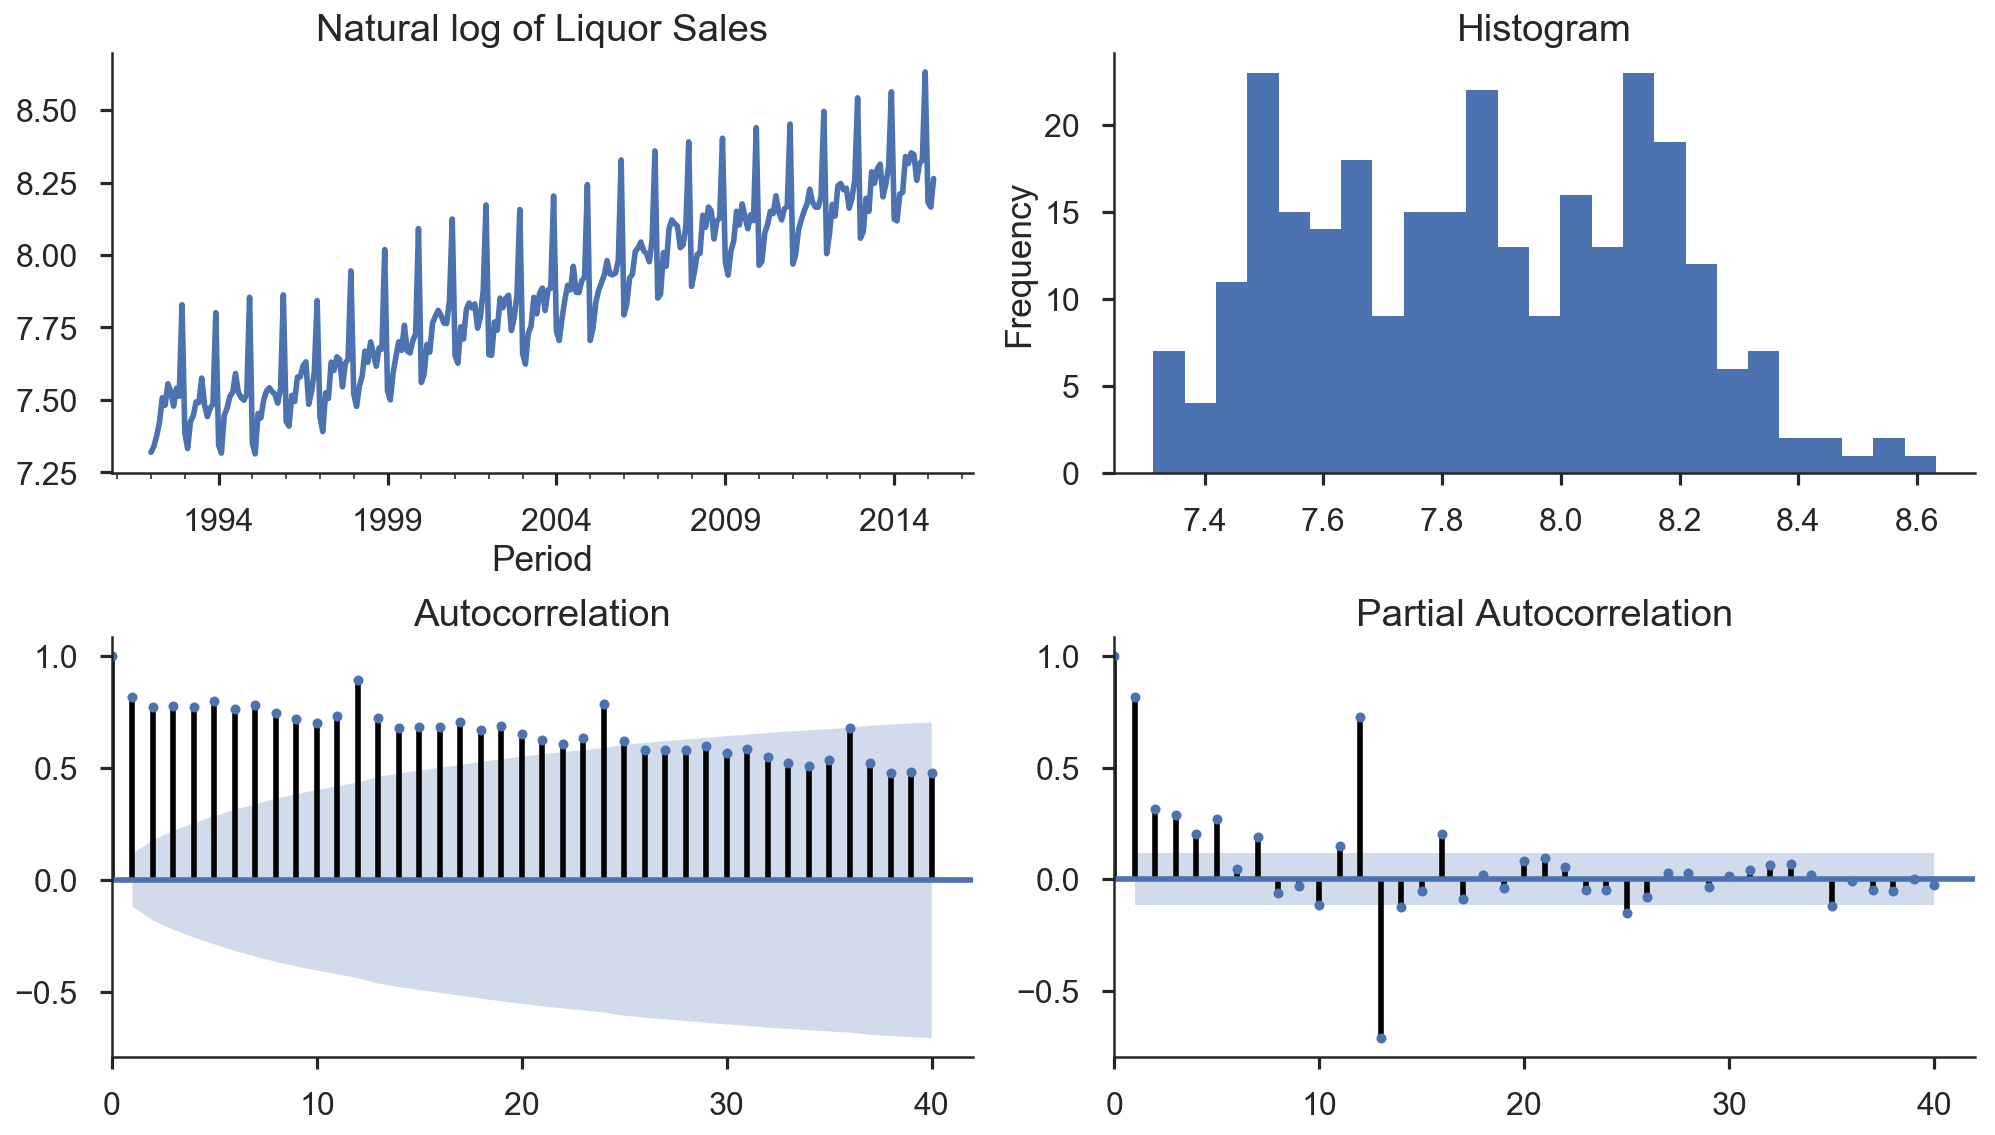

In [8]:
# Step 2c: Conduct log-transformation
ln_liq = np.log(liquor_train).dropna()
tsplot(ln_liq, title='Natural log of Liquor Sales', lags=40);

The log-transformation has reduced the variance in the time-series. The distribution has shifted towards normal but is still far off from a normal distribution. Let us see the results of the stationarity test.

In [9]:
test_stationarity(ln_liq)

Test Statistic                  0.41949
p-value                         0.98221
#Lags Used                     16.00000
Number of Observations Used   262.00000
Critical Value (1%)            -3.45556
Critical Value (5%)            -2.87264
Critical Value (10%)           -2.57268
dtype: float64

The p-value has decreased slightly but is still well above 0.05. Let us employ a difference of 1 in time-series and see the results of stationarity test.

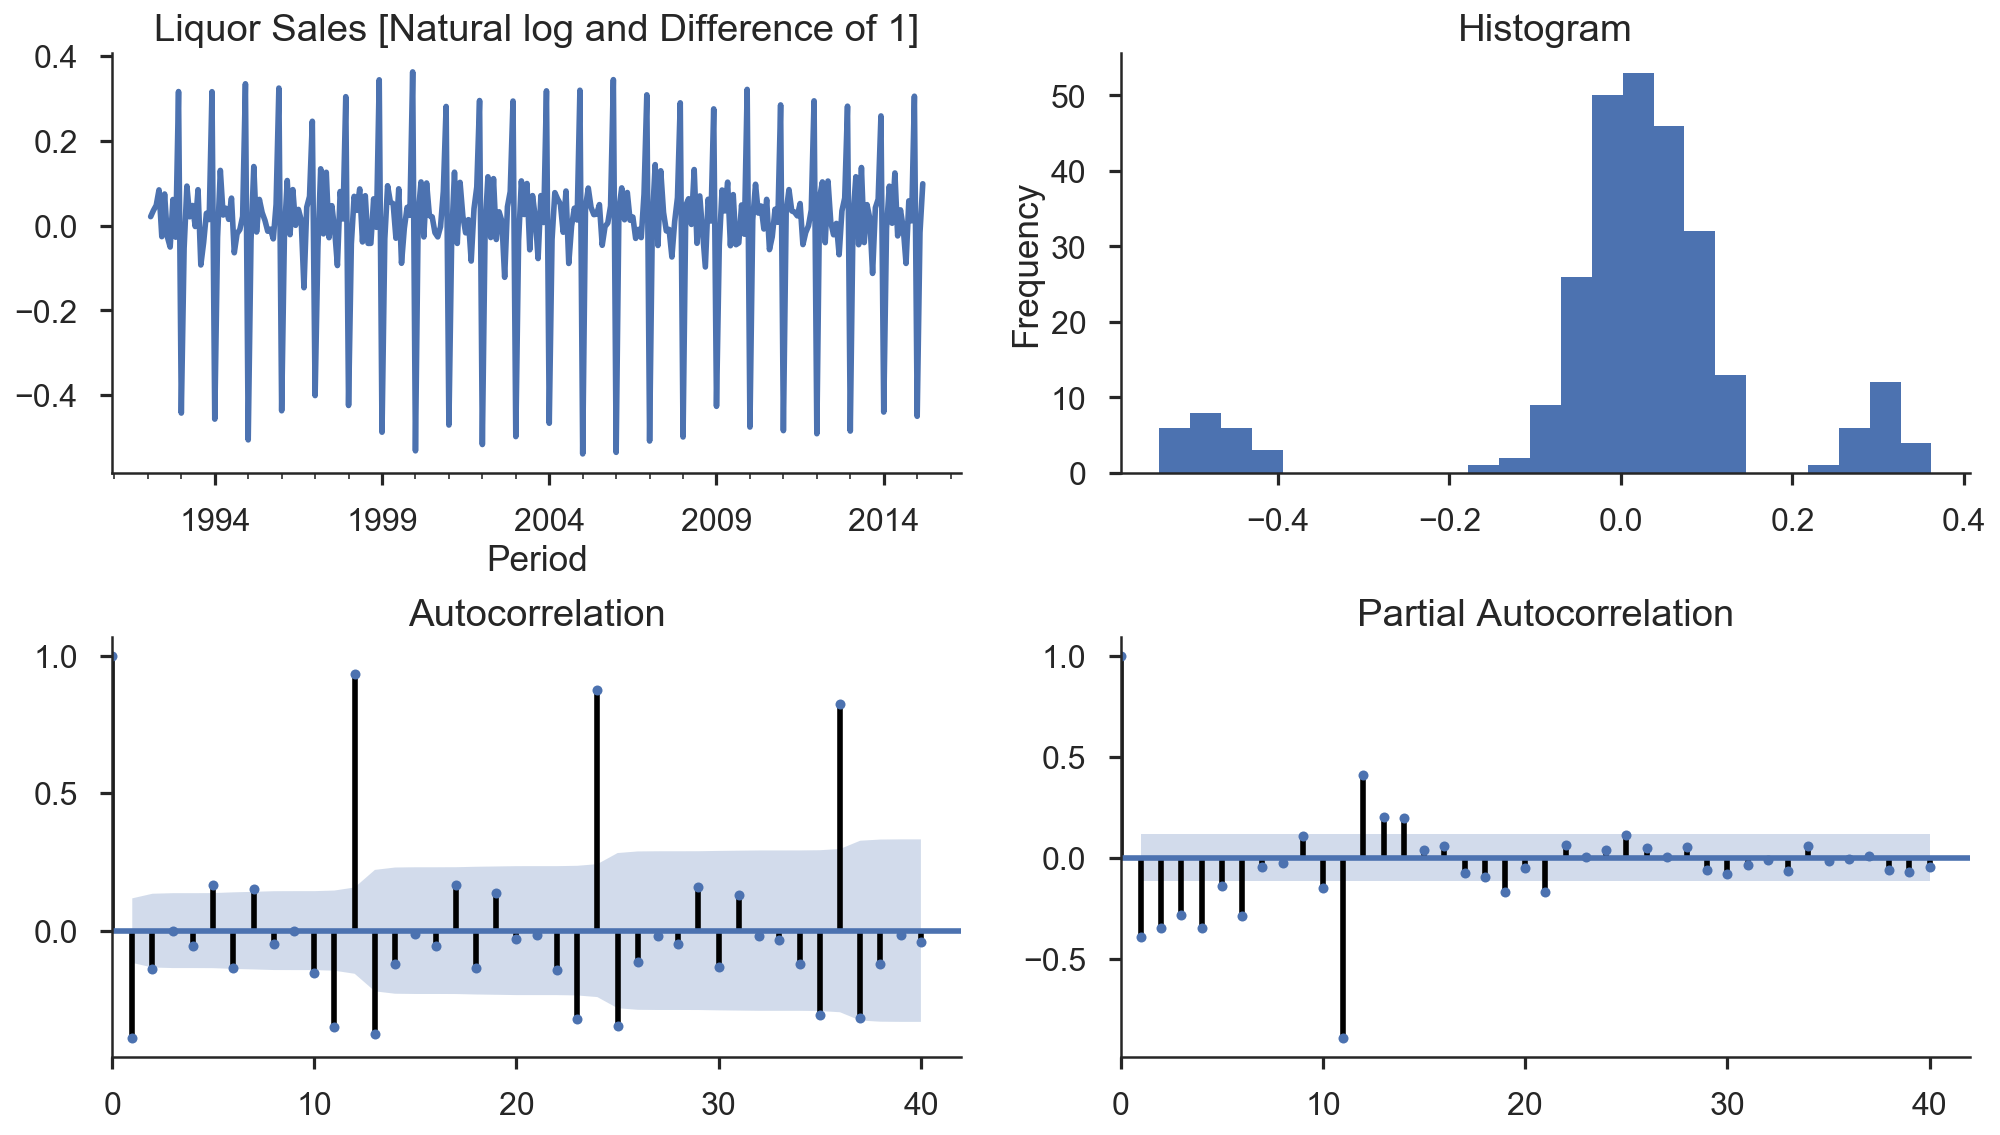

In [10]:
# Step 2d: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
liquor_train_diff = ln_liq.diff()
liquor_train_diff = liquor_train_diff.dropna()
tsplot(liquor_train_diff, title='Liquor Sales [Natural log and Difference of 1]', lags=40);

In [11]:
test_stationarity(liquor_train_diff)

Test Statistic                 -4.10740
p-value                         0.00094
#Lags Used                     16.00000
Number of Observations Used   261.00000
Critical Value (1%)            -3.45566
Critical Value (5%)            -2.87268
Critical Value (10%)           -2.57271
dtype: float64

From the above plots, we see that the time-series does not contain any trend and the variance is the same across the entire series. The histogram plot has significantly shifted towards a normal distribution. Also, the stationarity test reveals the p-value is way below 0.05. This time-series has satisfied the stationarity test. However, we need to reverse the transformations after the forecast is made to get the original series.

Now, we move to modeling the time-series. From the auto-correlation plot, it is clear that there is a high correlation at time-lags of 12 months which is also made evident from the plot below. This is an indication of seasonality. Therefore, we will use SARIMAX modeling with seasonality order.

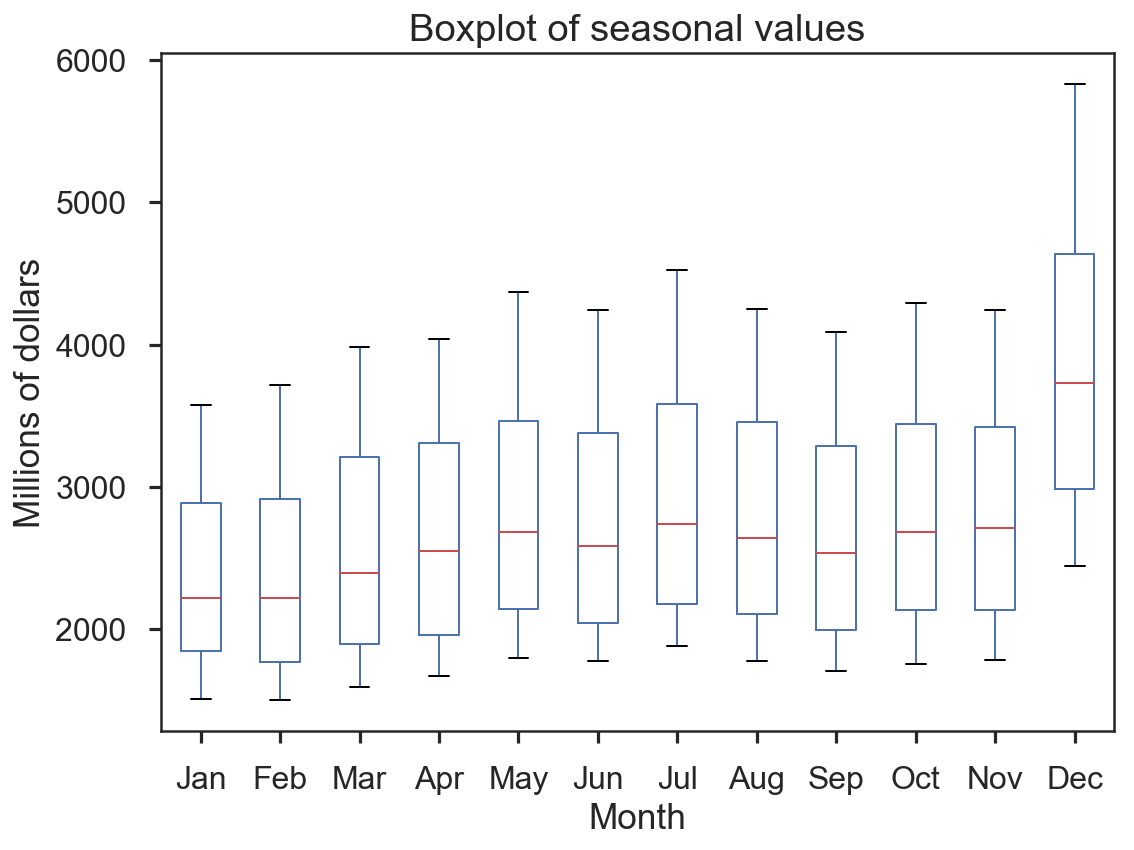

In [12]:
# An alternative way to detect seasonality
liq_copy = liquor.copy()
liq_copy['Month'] = liq_copy.index.strftime('%b')
liq_copy['Year'] = liq_copy.index.year

liq_copy_piv = liq_copy.pivot(index='Year', columns='Month', values='Value')

liq_copy = liq_copy.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
liq_copy_piv = liq_copy_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
liq_copy_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Millions of dollars');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

###  Step 3- SARIMAX Modeling - Seasonality Auto-Regressive Integrated Moving Average Exogenous regression model

A pure ARIMA (Auto-Regressive Integrated Moving Average) Regression Model has (p,d,q) as the order parameters to be specified. p represents the auto-regressive coefficient. 

For a time series ${z_t}$, if $z_t = z_{t-1} + \omega_t + \theta \omega_{t-1}$, i.e, the time-series is a function of previous value $z_{t-1}$, a random noise $\omega_t$ and some function $\theta$ of the previous random noise $\omega_{t-1}$.

$$\begin{align}
   z_t &= z_{t-1} + \omega_t + \theta \omega_{t-1} \\
   z_t - z_{t-1} &= \omega_t + \theta \omega_{t-1} \\
  (1-B)z_t &= (1+\theta B)\omega_t
\end{align}$$

where, B is the lag operator.

This is an ARIMA(0,1,1) model.

Seasonality is the repetition of time-series after few time-steps. For example 

$$ z_t = \Phi z_{t-12} + \epsilon_t + \Theta \epsilon_{t-12} $$ seasonality order is given by (sp,sd,sq,s).

$
Seasonality\,associated\,orders\\
sp-autoregressive\,order\\
sd-differencing\,order\\
sq-moving\,average\,order\\
s-seasonality - 12
$

This can be represented as:

$$ (1 - \Phi B^{12})z_t = (1 + \Theta B^{12})\epsilon_t $$

or a SARIMAX(1,0,1,12) model.

To choose the right model, we can run a grid-search.

In [13]:
liquor = pd.read_csv('data/liquor.csv', header=0, index_col=0, parse_dates=[0])
# Choose only those in training data
liquor = liquor.ix['1992':'2016']

In [14]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)
def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

In [15]:
# Original Source: PyData 2016
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [16]:
# Original Source: PyData 2016
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic
            
            #pred_begin = liquor_train.index[model_results.loglikelihood_burn]
            #pred_end = liquor_valid.index[-1]
            #pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
            #                                    end=pred_end.strftime('%Y-%m-%d'))
            
            #pred_mean = np.exp(pred.predicted_mean)
            #pred_mean = np.roll(liquor_train,d)[-14:]*np.exp(model_result.forecast(steps = 14))
            #rmse = get_rmse(liquor_valid, pred_mean.ix[liquor_valid.index])
            #mape = get_mape(liquor_valid, pred_mean.ix[liquor_valid.index])
            
            #this_model.loc[mod_num, 'mape'] = mape
            #this_model.loc[mod_num, 'rmse'] = rmse
            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

In [17]:
# Original Source: PyData 2016
# Step 3a: run model grid search
p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=12

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(ln_liq,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

The results of the grid search are sorted by 10 models which scored the lowest Bayesian Information Crietrion on the validation set as we want to use this model to forecast. With (p,d,q) = (2,1,0) and (sp,sd,sq,s) = (1,1,1,12), we run the SARIMAX model.

In [18]:
# choose a model
df_results.sort_values(by='bic').head(10)

,p,d,q,sP,sD,sQ,s,trend,enforce_stationarity,enforce_invertibility,simple_differencing,aic,bic,het_p,norm_p,sercor_p,dw_stat,arroots_gt_1,maroots_gt_1,datetime_run
75,2,1,0,1,1,1,12,n,True,True,False,-1210.79603,-1192.63997,0.04874,0.85992,0.00000,1.92175,True,True,2018-05-27 00:00:00
83,2,1,1,1,1,1,12,n,True,True,False,-1210.12642,-1188.33915,0.05251,0.84382,0.00000,1.99508,True,True,2018-05-27 00:00:00
73,2,1,0,1,0,1,12,n,True,True,False,-1202.59920,-1184.44314,0.12180,0.67510,0.00000,1.93725,True,True,2018-05-27 00:00:00
87,2,1,2,1,1,1,12,n,True,True,False,-1209.47396,-1184.05548,0.04195,0.96684,0.00000,1.98596,True,True,2018-05-27 00:00:00
71,2,1,0,0,1,1,12,n,True,True,False,-1194.66906,-1180.14421,0.11368,0.58377,0.00000,1.92438,True,True,2018-05-27 00:00:00
79,2,1,1,0,1,1,12,n,True,True,False,-1194.14946,-1175.99340,0.12355,0.54047,0.00000,2.00680,True,True,2018-05-27 00:00:00
85,2,1,2,0,1,1,12,n,True,True,False,-1194.67240,-1172.88513,0.08241,0.56165,0.00000,1.99605,True,True,2018-05-27 00:00:00
27,0,1,2,1,1,1,12,n,True,True,False,-1189.41460,-1171.25854,0.05523,0.66286,0.00000,2.09366,True,True,2018-05-27 00:00:00
81,2,1,1,1,0,1,12,n,True,True,False,-1192.64687,-1170.85960,0.02643,0.78310,0.00000,1.97116,True,True,2018-05-27 00:00:00
35,1,0,2,1,1,1,12,n,True,True,False,-1191.04262,-1169.25535,0.07159,0.68007,0.00000,2.11034,True,True,2018-05-27 00:00:00


In [19]:
# Step 3b - SARIMAX Model
mod = sm.tsa.statespace.SARIMAX(ln_liq, order=(2,1,0), seasonal_order=(1,1,1,12))
sarima_fit = mod.fit()
print(sarima_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  279
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 610.398
Date:                            Sun, 27 May 2018   AIC                          -1210.796
Time:                                    13:53:32   BIC                          -1192.640
Sample:                                01-01-1992   HQIC                         -1203.513
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8226      0.056    -14.583      0.000      -0.933      -0.712
ar.L2         -0.5037      0.055   

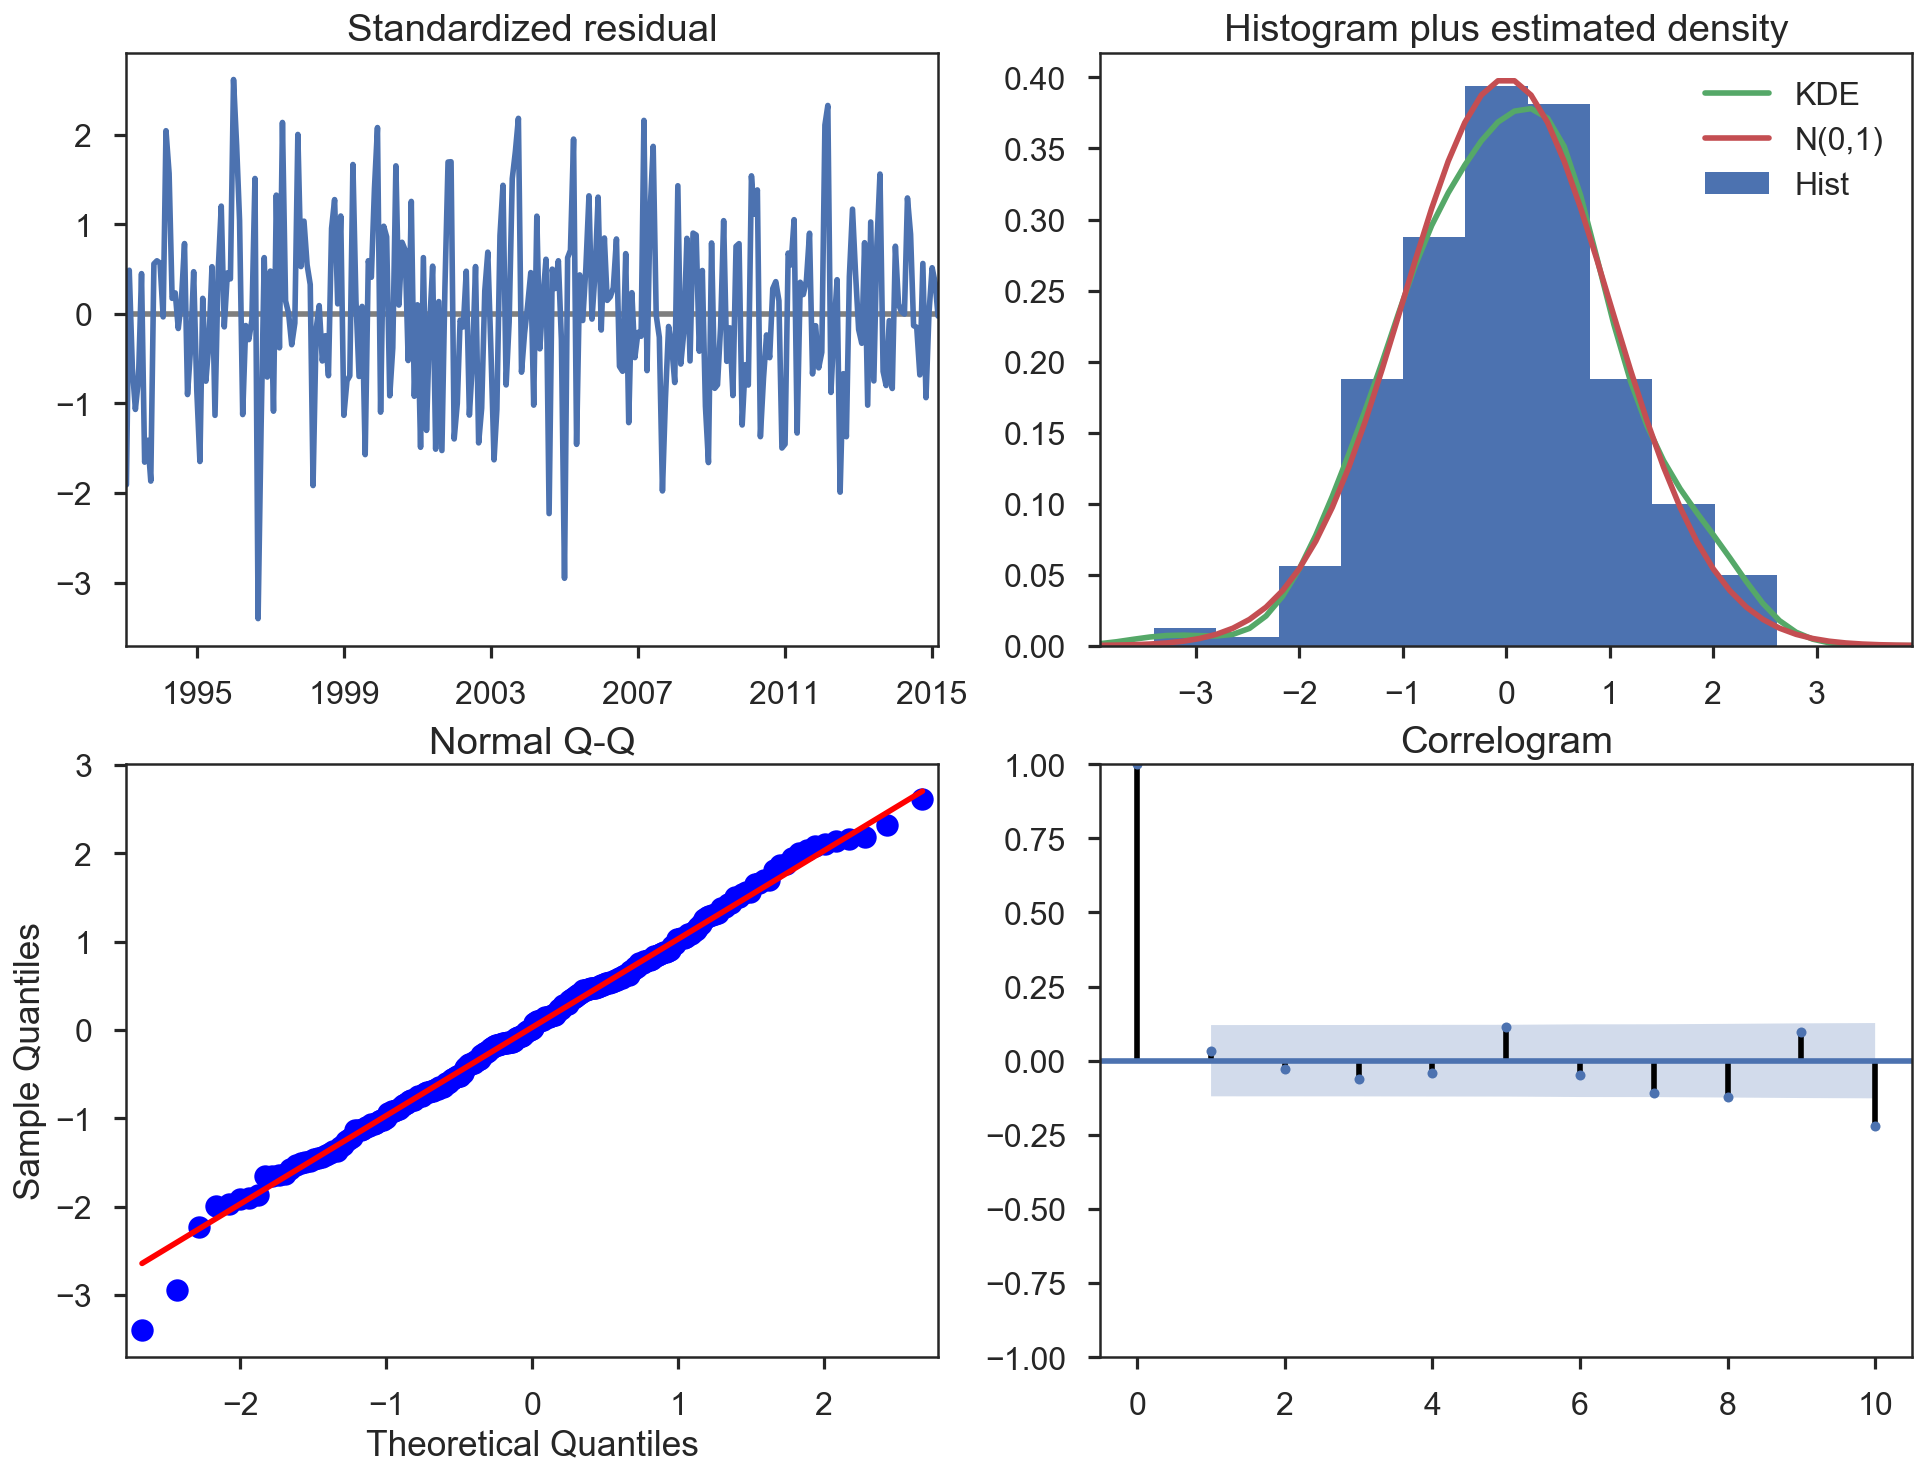

In [20]:
sarima_fit.plot_diagnostics(figsize=(16, 12));

From the above diagnostics plot, we can say that the distribution is of normal. The fit of the time-series from the model is good as per Normal Q-Q plot.

### Step 4 - Prediction and Analysis

Since the model runs on log-transformed values of time-series, predictions need to be re-transformed back to original by exponential. A 14-month forecast is done and plotted. The Root Mean Square Error and Maximum Absolute Percentage Error are also calculated.

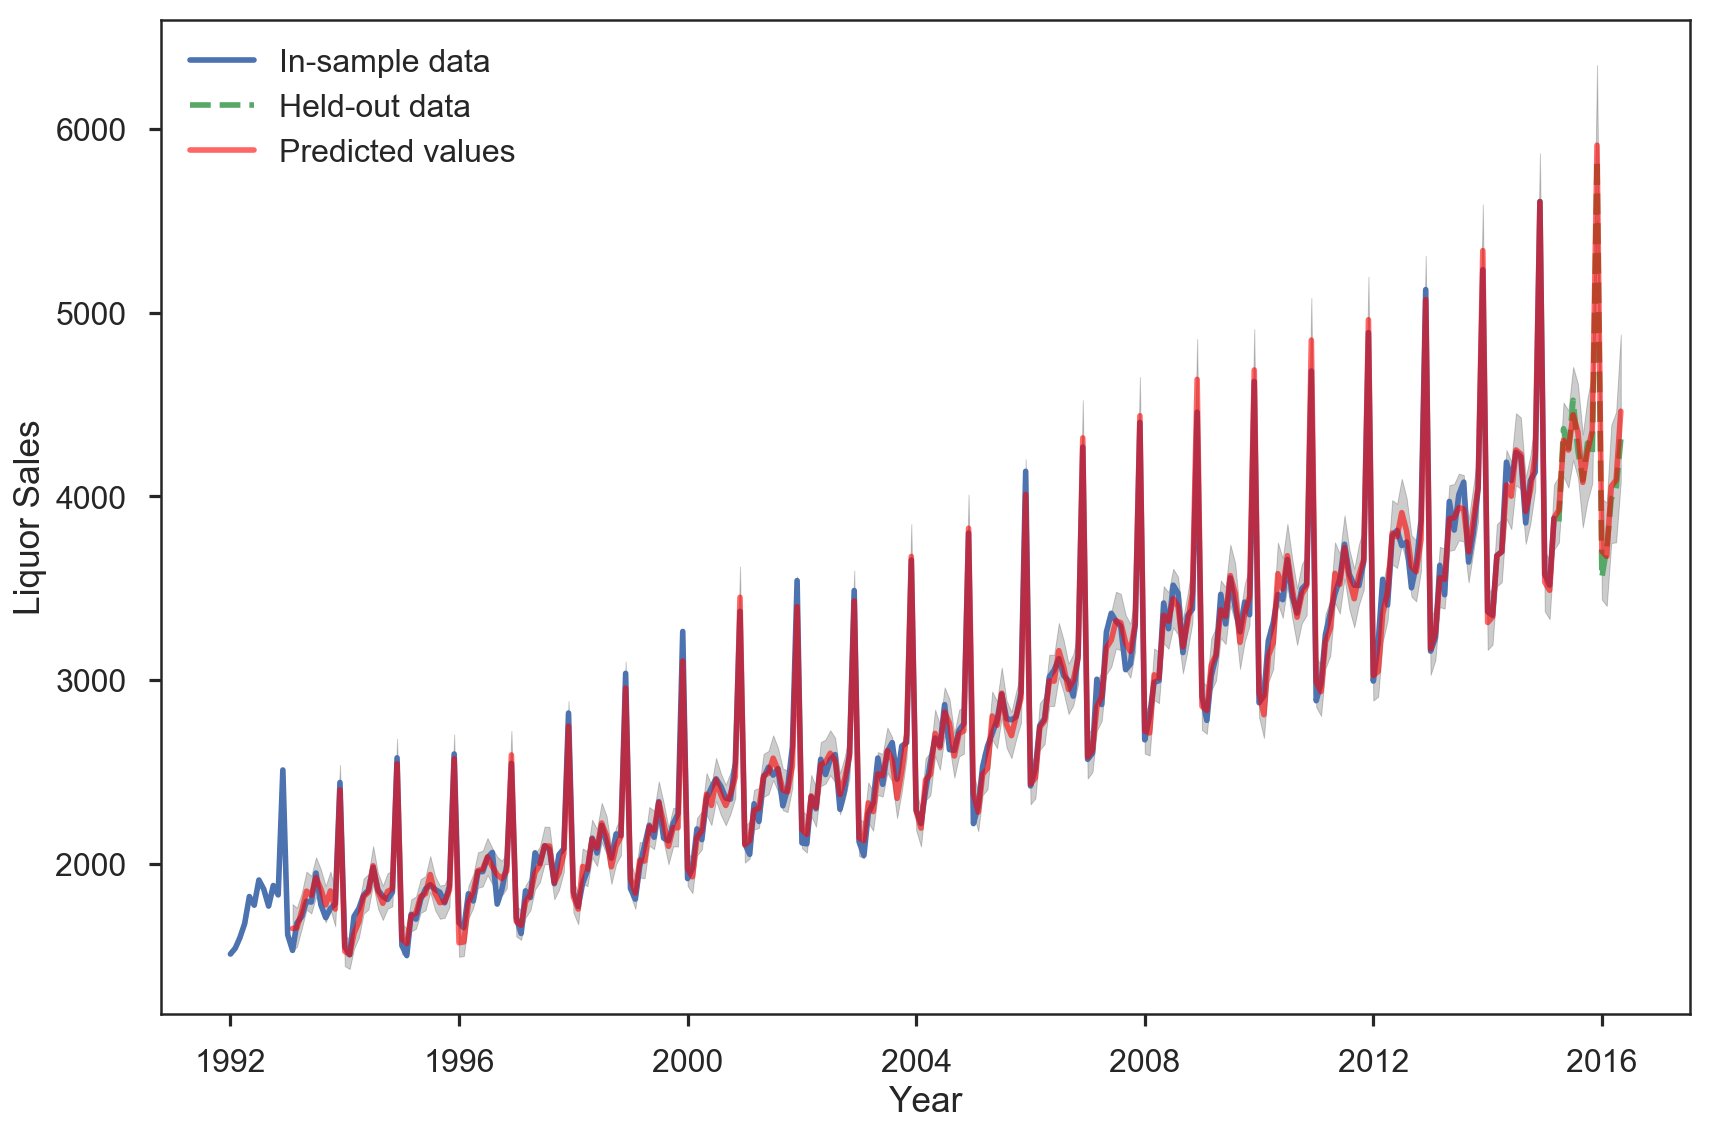

In [21]:
# Step 4a - Prediction and Plots
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(liquor_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(liquor_valid, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = liquor_train.index[sarima_fit.loglikelihood_burn]
pred_end = liquor_valid.index[-1]
pred = sarima_fit.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = np.exp(pred.predicted_mean)
pred_ci = np.exp(pred.conf_int(alpha=0.05))

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Liquor Sales")
ax1.legend(loc='best');
fig.tight_layout();
## Discuss the results.  How does your forecast look?

From the above plot, we can see that the predictions align well with the original time-series. 

In [22]:
# Step 4b - Analysis of Results
rmse = get_rmse(liquor_valid, pred_mean.ix[liquor_valid.index])
print("RMSE: ", rmse)
mape = get_mape(liquor_valid, pred_mean.ix[liquor_valid.index])
print("MAPE: ", mape)

RMSE:  84.54372764157347
MAPE:  1.7622810100185407


This 1.76% error amounts to 84.54 Million Dollars compared to the average monthly sale of 4237 Million Dollars in the validation period.